# Random Forests and Gradient Boosted Regression Trees

We will look here into the practicalities of fitting random forests and GBRT. These involve out-of-bound estmates and cross-validation, and how you might want to deal with hyperparameters in these models. Along the way we will play a little bit with different loss functions, so that you start thinking about what goes in general into cooking up a machine learning model.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## General Trees

We could use a simple Decision Tree regressor to fit such a model. Thats not the aim of this lab, so we'll run one such model without any cross-validation or regularization.

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

In [2]:
from sklearn.tree import DecisionTreeRegressor
x = np.arange(0, 2*np.pi, 0.1)
y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])

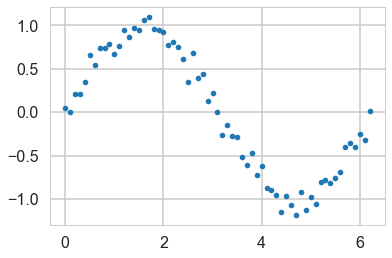

In [3]:
plt.plot(x,y, '.');

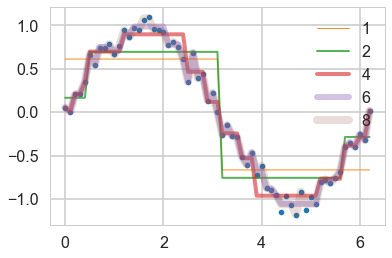

In [4]:
plt.plot(x,y,'.')
xx = x.reshape(-1,1)
for i in [1,2,4,6,8]:
    dtsin = DecisionTreeRegressor(max_depth=i)
    dtsin.fit(xx, y)
    plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
plt.legend();

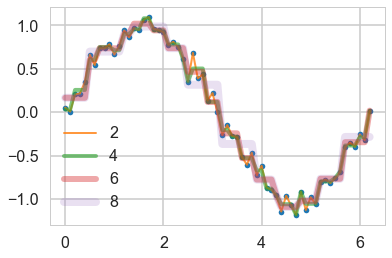

In [5]:
plt.plot(x,y,'.')
xx = x.reshape(-1,1)
for i in [2,4,6,8]:
    dtsin = DecisionTreeRegressor(min_samples_split=i)
    dtsin.fit(xx, y)
    plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
plt.legend();

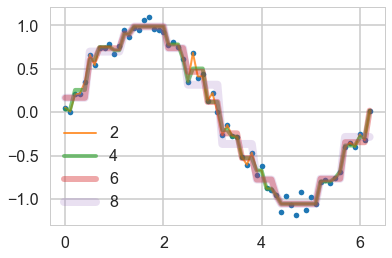

In [6]:
plt.plot(x,y,'.')
xx = x.reshape(-1,1)
for i in [2,4,6,8]:
    dtsin = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
    dtsin.fit(xx, y)
    plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
plt.legend();

Ok with this discussion in mind, lets approach Random Forests.

## Random Forests

Whats the basic idea?

- Decision trees overfit
- So lets introduce randomization.
- Randomization 1: Use bootstrap resampling to create different training datasets. This way each training will give us a different tree and the robust aspects of the regression will remain.
- Added advantage is that the left off points can be used to "validate"
- Just like in polynomials we can choose a large `max_depth` and we are ok as we expect the robust signal to remain

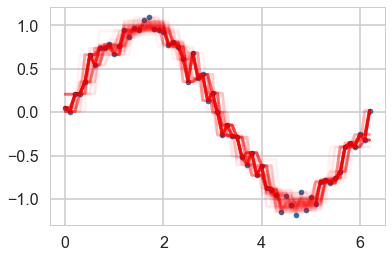

In [7]:
plt.plot(x,y,'.')
for i in range(100):
    dtsin = DecisionTreeRegressor(max_depth=6)
    isamp = np.random.choice(range(x.shape[0]), replace=True, size=x.shape[0])
    xx = x[isamp].reshape(-1,1)
    dtsin.fit(xx, y[isamp])
    plt.plot(x, dtsin.predict(x.reshape(-1,1)), 'r', alpha=0.05)

But this is not enough randomization, because even after bootstrapping, you are mainly training on the same data points, those that appear more often, and will retain some overfitting.

I cant do anything in 1 D but in more than 1D i can choose what predictors to split on randomly, and how many to do this on. This gets us a random forest.

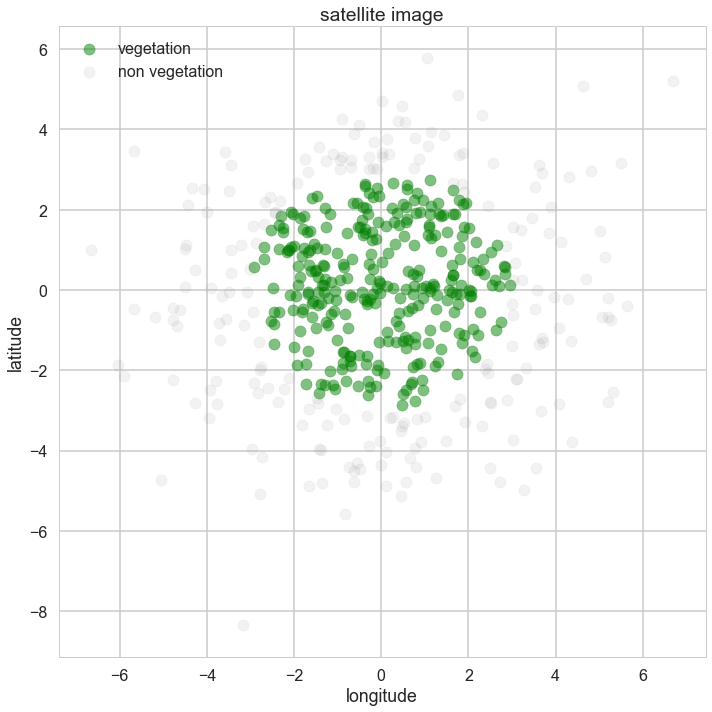

In [16]:
from sklearn.tree import DecisionTreeClassifier
npoints = 500 
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=npoints)
data = np.hstack((data, np.zeros((npoints, 1))))
data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = data[:, :-1]
y = data[:, -1]
ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation', alpha=0.5)
ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', label='non vegetation', alpha=0.1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('satellite image')
ax.legend()
plt.tight_layout()

In [18]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax, plot_data=True, fill=True, color='Greens', alpha=0.1):
    if plot_data:
        # PLOT DATA
        ax.scatter(x[y==1,0], x[y==1,1], c='blue')
        ax.scatter(x[y==0,0], x[y==0,1], c='black')
    
    # CREATE MESH
    interval = np.arange(min(x.min(), y.min()),max(x.max(), y.max()),0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if fill:
        ax.contourf(x1, x2, yy, alpha=alpha, cmap=color)
    else:
        ax.contour(x1, x2, yy, alpha=alpha, cmap=color)
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [21]:
from sklearn import tree
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax, plot_data=True, fill=True, color='Blues'):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax, plot_data, fill, color)
    
    return ax

(-3.2, 3.2)

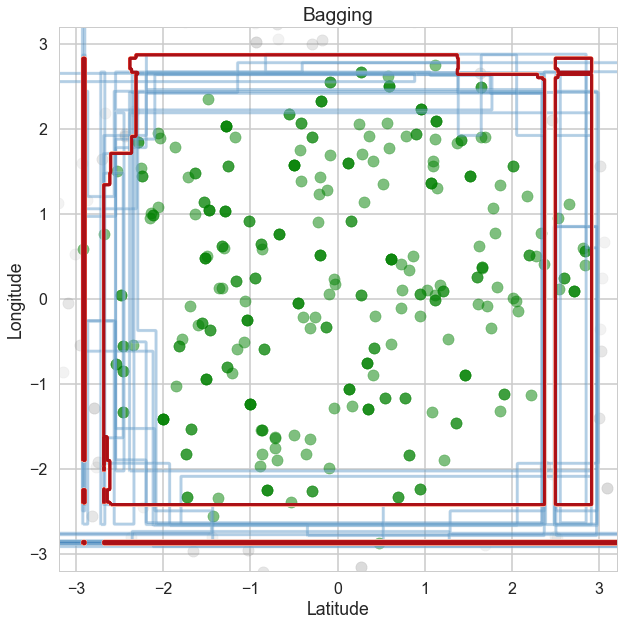

In [23]:
#Bagging
from sklearn import ensemble
depth = None

fig, ax = plt.subplots(1, 1, figsize=(10, 10))


for i in range(8):
    sample_ind = np.random.choice(range(len(data)), len(data), replace=True)
    bootstrap = data[sample_ind]
    x = bootstrap[:, :-1]
    y = bootstrap[:, -1]
    ax = fit_and_plot_dt(x, y, depth, '', ax, plot_data=False, fill=False) 
 
#KIND OF CHEATING BELOW BECAUSE Bagging will create its own bootstrap samples
bag = ensemble.BaggingClassifier(n_estimators=100)
bag.fit(x, y)

ax = plot_tree_boundary(x, y, bag, 'Bagging', ax, plot_data=False, fill=False, color='Reds', alpha=1.)

ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation', alpha=0.5)
ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', label='non vegetation', alpha=0.1)

ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-3.2, 3.2)


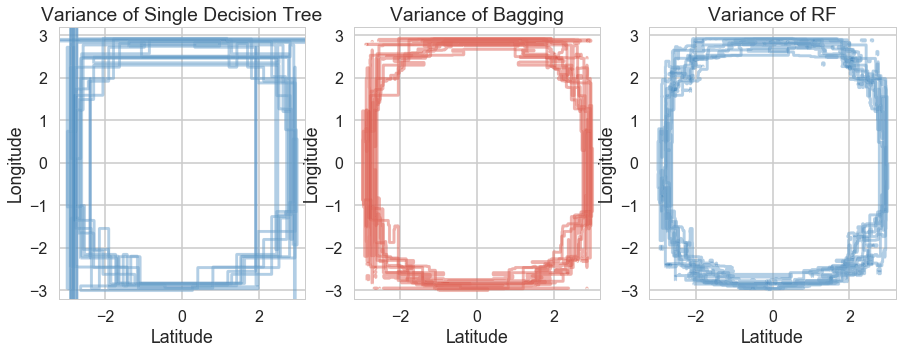

In [24]:
#Variance reduction: Baggining, RF, Tree
depth = None

fig, ax = plt.subplots(1, 3, figsize=(15, 5))


for i in range(8):
    new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=npoints)
    new_data = np.hstack((new_data, np.zeros((npoints, 1))))
    new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2, 2] = 1
    x = new_data[:, :-1]
    y = new_data[:, -1]

    ax[0] = fit_and_plot_dt(x, y, depth, 'Variance of Single Decision Tree', ax[0], plot_data=False, fill=False)
    
    bag = ensemble.BaggingClassifier(n_estimators=30)
    bag.fit(x, y)
    ax[1] = plot_tree_boundary(x, y, bag, 'Variance of Bagging', ax[1], plot_data=False, fill=False, color='Reds')
    
    rf = ensemble.RandomForestClassifier(n_estimators=30)
    rf.fit(x, y)
    ax[2] = plot_tree_boundary(x, y, rf, 'Variance of RF', ax[2], plot_data=False, fill=False, color='Blues')


    
ax[0].set_xlim(-3.2, 3.2)
ax[0].set_ylim(-3.2, 3.2)
ax[1].set_xlim(-3.2, 3.2)
ax[1].set_ylim(-3.2, 3.2)
ax[2].set_xlim(-3.2, 3.2)
ax[2].set_ylim(-3.2, 3.2)
plt.show() 

In [25]:
#Errors
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=200)
data = np.hstack((data, np.zeros((200, 1))))
data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(data[data[:, 0]**2 + data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x = data[:, :-1]
y = data[:, -1]

test_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=1000)
test_data = np.hstack((test_data, np.zeros((1000, 1))))
test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

dt = tree.DecisionTreeClassifier()
dt.fit(x, y)
tree_score = np.array([dt.score(x_test, y_test)] * len(range(20, 320, 10)))

bag_score = []
bag_oob = []
rf_score = []
rf_oob = []
for i in range(20, 320, 10):
    bag = ensemble.BaggingClassifier(n_estimators=i, oob_score=True)
    bag.fit(x, y)
    bag_score.append(bag.score(x_test, y_test))

    bag_oob.append(bag.oob_score_)
    
    rf = ensemble.RandomForestClassifier(n_estimators=i, oob_score=True)
    rf.fit(x, y)
    rf_score.append(rf.score(x_test, y_test))
    rf_oob.append(rf.oob_score_)

//anaconda/envs/py3l/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:603: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda/envs/py3l/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:608: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


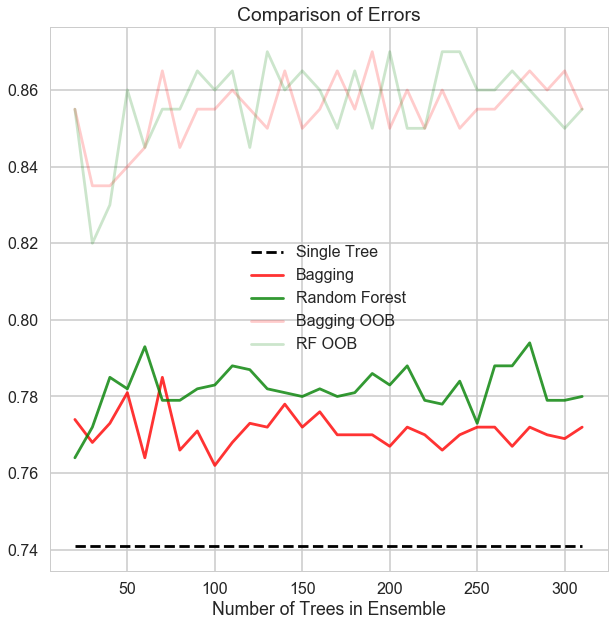

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
tree_score = np.array([dt.score(x_test, y_test)] * len(range(20, 320, 10)))
ax.plot(range(20, 320, 10), tree_score, color='black', linestyle='--', label='Single Tree')
ax.plot(range(20, 320, 10), bag_score, color='red', alpha=0.8, label='Bagging')
ax.plot(range(20, 320, 10), rf_score, color='green', alpha=0.8, label='Random Forest')
ax.plot(range(20, 320, 10), bag_oob, color='red', alpha=0.2, label='Bagging OOB')
ax.plot(range(20, 320, 10), rf_oob, color='green', alpha=0.2, label='RF OOB')
ax.set_title('Comparison of Errors')
ax.set_xlabel('Number of Trees in Ensemble')
ax.legend(loc='best')
plt.show()

## Gradient Boosted Regression Trees

Adaboost Classification, which you will be doing in your homework, is a special case of a gradient-boosted algorithm. Gradient Bossting is very state of the art, and has major connections to logistic regression, gradient descent in a functional space, and search in information space. See Shapire and Freund's MIT Press book for details.

But briefly, let us cover the idea here. The idea is that we will use a bunch of weak learners and fit sequentially. The first one fits the signal, the second one the first residual, the third the second residual and so on. At each stage we upweight the places that our previous learner did badly on. First let us illustrate.

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
estgb = GradientBoostingRegressor(n_estimators=500, max_depth=1, learning_rate=1.0)
estgb.fit(x.reshape(-1,1), y)
staged_predict_generator = estgb.staged_predict(x.reshape(-1,1))

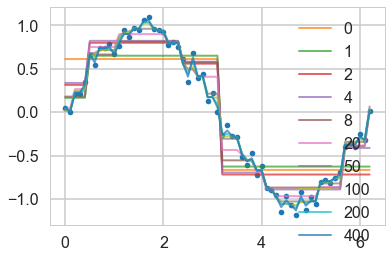

In [13]:
# code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
import time
from IPython import display
plt.plot(x, y, '.');
i = 0 
counter = 0
for stagepred in staged_predict_generator:
    if i in [0, 1, 2, 4, 8, 20, 50, 100, 200, 400, 500]:
        plt.plot(x, stagepred, alpha=0.7, label=str(i), lw=2)
        plt.legend();
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(2 - counter*0.1)
        counter = counter + 1
    i = i + 1

Ok, so this demonstration helps us understand some things about GBRT.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` to increase the bias.

YOUR TURN NOW

>Demonstrate what happens when you increase `max_depth` to 5

In [14]:
# your code here

YOUR TURN NOW

> What happens if you put `max_depth` back to 1 and decrease the learning rate to 0.1?

In [15]:
# your code here

### Whats the relationship between residuals and the gradient?

Pavlos showed in class that for the squared loss, taking the gradient in the "data point functional space", ie a N-d space for N data points with each variable being $f(x_i)$ just gives us the residuals. It turns out that the gradient descent is the more general idea, and one can use this for different losses. And the upweighting of poorly fit points in AdaBoost is simply a weighing by gradient. If the gradient (or residual) is high it means you are far away from optimum in this functional space, and if you are at 0, you have a flat gradient!

The ideas from the general theory of gradient descent tell us this: we can slow the learning by shrinking the predictions of each tree by some small number, which is called the learning_rate (learning_rate). This "shrinkage" helps us not overshoot, but for a finite number of iterations also simultaneously ensures we dont overfit by being in the neighboorhood of the minimum rather than just at it! But we might need to increase the iterations some to get into the minimum area.

Unlike random forests, where we are using the randomness to our benefits, the GBRT requires careful cross-validation

Peter Prettenhofer, who wrote sklearns GBRT implementation writes in his pydata14 talk (worth watching!)

>Hyperparameter tuning
I usually follow this recipe to tune the hyperparameters:

>- Pick n_estimators as large as (computationally) possible (e.g. 3000)
- Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search
- A lower learning_rate requires a higher number of n_estimators. Thus increase n_estimators even more and tune learning_rate again holding the other parameters fixed

This last point is a tradeof between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

Let me add however, that poor learners do rather well. So you might want to not cross-validate `max_depth`. And `min_samples_per_leaf` is not independent either, so if you do use cross-val, you might just use one of those.

### Tips:

- ordinal encoding in trees for categorical variables is as effective as one-hot encoding but more efficient, using less memory and being faster. But your trees need to be deeper as you are making more cuts
- often explicit interactions  are useful in GBRT even tho it detects interactions